In [36]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.sans-serif"]=["WenQuanYi Micro Hei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 禁止随机，结果可复现
random.seed(42)
np.random.seed(42)

## 超参数选择

In [46]:
emo_index = ['上证综合情绪值', '沪深300情绪值', '创业板情绪值'][2]
model = 'Deep-learning/BERT'

ROOT_PATH = '/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Temporal_Clustering'
Clustering_Method = 'Other_Clusters'
Emotion_Data_PATH = f'{ROOT_PATH}/data/Emotion_Data/{model}'   # 情绪数据路径
Financial_Data_PATH = f'{ROOT_PATH}/data/Financial_Data' # 金融数据路径

os.makedirs(f'{ROOT_PATH}/{Clustering_Method}/个股分析/基于特征的聚类/{emo_index}', exist_ok=True)

print(f"Running with: emo_index={emo_index}, model={model}")

Running with: emo_index=创业板情绪值, model=Deep-learning/BERT


## 数据准备

In [38]:
"""读取股吧个股的数据"""
all_data = []
file_list = [f for f in os.listdir(Emotion_Data_PATH) if f.endswith('.csv')]

for file in file_list:
    file_path = os.path.join(Emotion_Data_PATH, file)
    df = pd.read_csv(file_path)
    stock_code = os.path.splitext(file)[0] # 获取股票编号（文件名去掉扩展名）
    
    # 提取每一行的日期和情绪值
    for _, row in df.iterrows():
        new_row = {
            '股票编号': stock_code,
            '日期': row['日期'],
            '上证综合情绪值': row['上证综合情绪值'],
            '沪深300情绪值': row['沪深300情绪值'],
            '创业板情绪值': row['创业板情绪值']
        }
        all_data.append(new_row)
        
guba_data = pd.DataFrame(all_data)
guba_data

,股票编号,日期,上证综合情绪值,沪深300情绪值,创业板情绪值
0,601933,2024-12-27,0.007,-0.044,-0.015
1,601933,2024-11-18,-0.155,-0.236,-0.354
2,601933,2024-11-17,0.001,0.022,0.004
3,601933,2024-11-17,-0.346,-0.337,-0.407
4,601933,2024-11-17,-0.247,-0.309,-0.358
...,...,...,...,...,...
495326,601919,2021-04-09,0.253,0.327,0.457
495327,601919,2021-04-09,-0.177,-0.190,-0.196
495328,601919,2021-04-08,0.218,0.194,0.167
495329,601919,2021-04-08,0.148,0.142,0.346


In [39]:
"""读取股票回报率的数据"""
return_data = pd.read_csv(f'{Financial_Data_PATH}/日个股回报率.csv', dtype={'股票编号': str})
return_data

,股票编号,日期,交易量,收益率变化
0,000002,2021-06-01,60990961,-0.003745
1,000002,2021-06-02,85354506,0.006015
2,000002,2021-06-03,50594187,-0.003363
3,000002,2021-06-04,71422364,-0.012748
4,000002,2021-06-07,64745280,-0.014812
...,...,...,...,...
154877,688981,2024-11-20,58507495,-0.017071
154878,688981,2024-11-21,56197106,0.002358
154879,688981,2024-11-22,79240108,-0.050588
154880,688981,2024-11-25,76905909,-0.029402


In [40]:
# 进行左连接，guba_data 为主表
merged_data = pd.merge(guba_data, return_data[['股票编号', '日期', '交易量', '收益率变化']], 
                       on=['股票编号', '日期'], 
                       how='left')
merged_data = merged_data.dropna()
merged_data

,股票编号,日期,上证综合情绪值,沪深300情绪值,创业板情绪值,交易量,收益率变化
1,601933,2024-11-18,-0.155,-0.236,-0.354,310012824.0,-0.004608
11,601933,2024-11-15,-0.178,-0.191,-0.171,423271473.0,-0.064655
12,601933,2024-11-15,0.072,0.066,0.130,423271473.0,-0.064655
13,601933,2024-11-14,-0.019,0.027,0.068,372259052.0,-0.053061
14,601933,2024-11-14,-0.006,0.012,0.003,372259052.0,-0.053061
...,...,...,...,...,...,...,...
495148,601919,2021-06-01,0.265,0.327,0.476,268816321.0,0.045859
495149,601919,2021-06-01,-0.006,0.002,0.020,268816321.0,0.045859
495150,601919,2021-06-01,-0.034,-0.003,0.016,268816321.0,0.045859
495151,601919,2021-06-01,0.041,0.018,0.071,268816321.0,0.045859


## 数据预处理

In [41]:
# Step 1: 对情绪值列进行 Min-Max 标准化
def min_max_normalization(df, cols):
    for col in cols:
        min_val = df[col].min()
        max_val = df[col].max()
        df[col] = 2 * (df[col] - min_val) / (max_val - min_val) - 1
    return df

# Step 2: 对每个股票编号的数据进行标准化和按日期汇总
def process_data(df):
    df_processed = pd.DataFrame()  # 用于存储结果
    for stock_code, stock_data in df.groupby('股票编号'):
        # 对每个股票编号内的数据进行标准化
        stock_data = min_max_normalization(stock_data, ['上证综合情绪值', '沪深300情绪值', '创业板情绪值'])
        
        # 按日期汇总数据，同时保留股票编号
        stock_summary = stock_data.groupby('日期').agg({
            '股票编号': 'first',  # 保留股票编号（在同一日期内它是相同的，使用 'first'）
            '上证综合情绪值': 'mean',  # 上证综合情绪值按日期取均值
            '沪深300情绪值': 'mean',  # 沪深300情绪值按日期取均值
            '创业板情绪值': 'mean',  # 创业板情绪值按日期取均值
            '交易量': 'mean',  # 交易量按日期求和
            '收益率变化': 'mean'  # 收益率变化按日期取均值
        }).reset_index(drop=False)
        
        df_processed = pd.concat([df_processed, stock_summary], ignore_index=True)
    
    return df_processed

# 调用处理函数
final_data = process_data(merged_data)
final_data

,日期,股票编号,上证综合情绪值,沪深300情绪值,创业板情绪值,交易量,收益率变化
0,2021-06-01,000002,0.316338,0.267833,0.280789,60990961.0,-0.003745
1,2021-06-08,000002,0.347227,0.287914,0.300312,44676494.0,0.004626
2,2021-06-10,000002,0.325725,0.281754,0.289027,53800776.0,-0.010035
3,2021-06-11,000002,0.285945,0.224180,0.235237,75853738.0,-0.014035
4,2021-06-15,000002,0.314849,0.268572,0.283593,89915501.0,-0.020957
...,...,...,...,...,...,...,...
85724,2024-11-12,688981,0.360433,0.328320,0.235728,108866759.0,-0.036864
85725,2024-11-13,688981,0.269057,0.242652,0.142033,80759477.0,-0.019484
85726,2024-11-14,688981,0.286646,0.247683,0.160005,76194102.0,-0.022897
85727,2024-11-15,688981,0.244977,0.218178,0.099522,71066743.0,-0.020233


## 基于特征的聚类

In [42]:
df = final_data[['日期', '股票编号', '上证综合情绪值', '收益率变化']].copy()
df['日期'] = pd.to_datetime(df['日期'])

# 提取每支股票的统计和趋势特征
def extract_features(group):
    group = group.sort_values(by='日期')
    features = {}

    # 上证情绪值
    sz = group['上证综合情绪值']
    features['情绪_均值'] = sz.mean()
    features['情绪_方差'] = sz.var()
    features['情绪_最大值'] = sz.max()
    features['情绪_最小值'] = sz.min()
    features['情绪_最后值'] = sz.iloc[-1]
    features['情绪_趋势'] = np.polyfit(range(len(sz)), sz, 1)[0]  # 拟合斜率表示趋势

    # 收益率
    ret = group['收益率变化']
    features['收益率_均值'] = ret.mean()
    features['收益率_方差'] = ret.var()
    features['收益率_最大跌'] = ret.min()
    features['收益率_最大涨'] = ret.max()
    features['收益率_最后值'] = ret.iloc[-1]
    features['收益率_趋势'] = np.polyfit(range(len(ret)), ret, 1)[0]

    return pd.Series(features)

# 按股票编号提取特征
features_df = df.groupby('股票编号').apply(extract_features)
features_df

/tmp/ipykernel_2094796/3438273638.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_df = df.groupby('股票编号').apply(extract_features)


,情绪_均值,情绪_方差,情绪_最大值,情绪_最小值,情绪_最后值,情绪_趋势,收益率_均值,收益率_方差,收益率_最大跌,收益率_最大涨,收益率_最后值,收益率_趋势
股票编号,,,,,,,,,,,,
000002,0.325232,0.002633,0.610222,0.021958,0.321548,1.594950e-06,-0.001376,0.000636,-0.100193,0.100437,-0.026816,0.000002
000061,0.398932,0.015175,1.000000,-0.214502,0.445207,3.099919e-04,0.000404,0.000266,-0.038153,0.079304,0.027221,-0.000003
000063,0.421707,0.003413,0.657805,-0.149557,0.468575,2.849168e-07,0.000499,0.000646,-0.099706,0.100161,-0.019733,0.000003
000069,-0.169180,0.018740,1.000000,-0.689663,-0.121666,8.135306e-05,-0.000917,0.000605,-0.069444,0.101887,-0.030717,0.000012
000100,-0.022380,0.006126,0.341941,-0.538431,-0.045189,1.646565e-05,0.000017,0.000477,-0.098121,0.100642,-0.024390,0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...
603986,0.165281,0.010067,0.500709,-0.627964,0.131915,-1.265408e-05,0.000741,0.000993,-0.100024,0.100047,-0.028519,0.000005
688005,0.009524,0.009310,0.346847,-0.879173,0.058824,7.019715e-05,0.001284,0.001425,-0.176610,0.182759,-0.012737,0.000030
688027,0.054734,0.010311,0.468786,-0.682562,0.087768,7.519318e-05,0.005550,0.001820,-0.136427,0.199337,-0.053935,0.000021


In [43]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

features_df['聚类标签'] = clusters
features_df[['聚类标签']]

,聚类标签
股票编号,
000002,2
000061,2
000063,2
000069,0
000100,0
...,...
603986,0
688005,1
688027,1


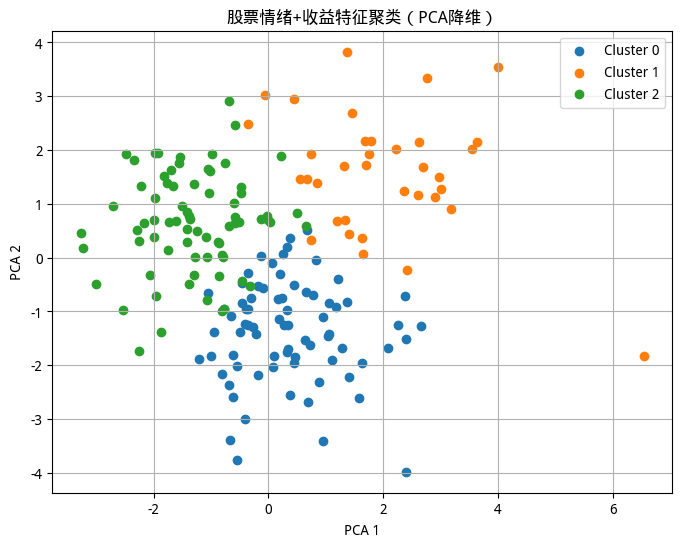

In [44]:
# 可视化（降维后展示）
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for label in range(k):
    plt.scatter(X_pca[clusters == label, 0], X_pca[clusters == label, 1], label=f'Cluster {label}')
plt.title("股票情绪+收益特征聚类（PCA降维）")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.savefig(f'{ROOT_PATH}/{Clustering_Method}/个股分析/基于特征的聚类/{emo_index}/Clustering_of_Stocks3.png')
plt.show()
plt.close()

In [45]:
features_df = features_df.reset_index().rename(columns={'股票编号': 'Stkcd'})
company_info_df = pd.read_csv(f'{Financial_Data_PATH}/中国公司代码.csv', dtype={'Stkcd': str})

features_df['Stkcd'] = features_df['Stkcd'].astype(str)
company_info_df['Stkcd'] = company_info_df['Stkcd'].astype(str)

# 左连接，获取公司名称
merged_df = pd.merge(features_df[['Stkcd', '聚类标签']], company_info_df[['Stkcd', 'Stknme']], on='Stkcd', how='left')

merged_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/基于特征的聚类/{emo_index}/clusters_results.csv', index=False)
merged_df

,Stkcd,聚类标签,Stknme
0,000002,2,万科A
1,000061,2,农产品
2,000063,2,中兴通讯
3,000069,0,华侨城A
4,000100,0,TCL科技
...,...,...,...
178,603986,0,兆易创新
179,688005,1,容百科技
180,688027,1,国盾量子
181,688029,0,南微医学
